# Downloading & Importing Packages
---

In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import scipy as sc

import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from scipy.linalg import norm

from sklearn import preprocessing

from typing import List
from utils import *
import re
import numpy as np
from collections import Counter
import torch.nn

from numpy.linalg import norm

# Connecting to Drive
---

In [ ]:
%cd /content
!rm -rf Datathon_F22
!git clone https://github.com/sunnydigital/Datathon_F22
%cd Datathon_F22

/content
Cloning into 'Datathon_F22'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 20 (delta 0), reused 4 (delta 0), pack-reused 15
Unpacking objects: 100% (20/20), done.
/content/Datathon_F22


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data
---

In [ ]:
trans_df = pd.read_csv('datasets/product_category_name_translation.csv')

og_cat_name = trans_df['product_category_name'].to_numpy()
og_cat_name = np.append(og_cat_name, ['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer', 'pcs', 'other'])
og_name_to_i = {}
for i, name in enumerate(og_cat_name):
  og_name_to_i[name] = i

display(og_name_to_i)

product_categories = trans_df['product_category_name_english'].to_numpy()
product_categories = np.append(product_categories, ['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer', 'pcs', 'other'])
display(product_categories)


product_categories_list = []
for category in product_categories:
   product_categories_list.append(re.split('_| ', category))

product_categories_list

{'beleza_saude': 0,
 'informatica_acessorios': 1,
 'automotivo': 2,
 'cama_mesa_banho': 3,
 'moveis_decoracao': 4,
 'esporte_lazer': 5,
 'perfumaria': 6,
 'utilidades_domesticas': 7,
 'telefonia': 8,
 'relogios_presentes': 9,
 'alimentos_bebidas': 10,
 'bebes': 11,
 'papelaria': 12,
 'tablets_impressao_imagem': 13,
 'brinquedos': 14,
 'telefonia_fixa': 15,
 'ferramentas_jardim': 16,
 'fashion_bolsas_e_acessorios': 17,
 'eletroportateis': 18,
 'consoles_games': 19,
 'audio': 20,
 'fashion_calcados': 21,
 'cool_stuff': 22,
 'malas_acessorios': 23,
 'climatizacao': 24,
 'construcao_ferramentas_construcao': 25,
 'moveis_cozinha_area_de_servico_jantar_e_jardim': 26,
 'construcao_ferramentas_jardim': 27,
 'fashion_roupa_masculina': 28,
 'pet_shop': 29,
 'moveis_escritorio': 30,
 'market_place': 31,
 'eletronicos': 32,
 'eletrodomesticos': 33,
 'artigos_de_festas': 34,
 'casa_conforto': 35,
 'construcao_ferramentas_ferramentas': 36,
 'agro_industria_e_comercio': 37,
 'moveis_colchao_e_estofad

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

[['health', 'beauty'],
 ['computers', 'accessories'],
 ['auto'],
 ['bed', 'bath', 'table'],
 ['furniture', 'decor'],
 ['sports', 'leisure'],
 ['perfumery'],
 ['housewares'],
 ['telephony'],
 ['watches', 'gifts'],
 ['food', 'drink'],
 ['baby'],
 ['stationery'],
 ['tablets', 'printing', 'image'],
 ['toys'],
 ['fixed', 'telephony'],
 ['garden', 'tools'],
 ['fashion', 'bags', 'accessories'],
 ['small', 'appliances'],
 ['consoles', 'games'],
 ['audio'],
 ['fashion', 'shoes'],
 ['cool', 'stuff'],
 ['luggage', 'accessories'],
 ['air', 'conditioning'],
 ['construction', 'tools', 'construction'],
 ['kitchen', 'dining', 'laundry', 'garden', 'furniture'],
 ['costruction', 'tools', 'garden'],
 ['fashion', 'male', 'clothing'],
 ['pet', 'shop'],
 ['office', 'furniture'],
 ['market', 'place'],
 ['electronics'],
 ['home', 'appliances'],
 ['party', 'supplies'],
 ['home', 'confort'],
 ['costruction', 'tools', 'tools'],
 ['agro', 'industry', 'and', 'commerce'],
 ['furniture', 'mattress', 'and', 'upholste

## GloVe Embeddings
---

Below we crate classes to import GloVe-50d embeddings for words in the English Dictionary

*Note* Need to run this entire block after

In [ ]:
class Indexer(object):
    """
    Bijection between objects and integers starting at 0. Useful for mapping
    labels, features, etc. into coordinates of a vector space.

    Attributes:
        objs_to_ints
        ints_to_objs
    """
    def __init__(self):
        self.objs_to_ints = {}
        self.ints_to_objs = {}

    def __repr__(self):
        return str([str(self.get_object(i)) for i in range(0, len(self))])

    def __str__(self):
        return self.__repr__()

    def __len__(self):
        return len(self.objs_to_ints)

    def get_object(self, index):
        """
        :param index: integer index to look up
        :return: Returns the object corresponding to the particular index or None if not found
        """
        if (index not in self.ints_to_objs):
            return None
        else:
            return self.ints_to_objs[index]

    def contains(self, object):
        """
        :param object: object to look up
        :return: Returns True if it is in the Indexer, False otherwise
        """
        return self.index_of(object) != -1

    def index_of(self, object):
        """
        :param object: object to look up
        :return: Returns -1 if the object isn't present, index otherwise
        """
        if (object not in self.objs_to_ints):
            return -1
        else:
            return self.objs_to_ints[object]

    def add_and_get_index(self, object, add=True):
        """
        Adds the object to the index if it isn't present, always returns a nonnegative index
        :param object: object to look up or add
        :param add: True by default, False if we shouldn't add the object. If False, equivalent to index_of.
        :return: The index of the object
        """
        if not add:
            return self.index_of(object)
        if (object not in self.objs_to_ints):
            new_idx = len(self.objs_to_ints)
            self.objs_to_ints[object] = new_idx
            self.ints_to_objs[new_idx] = object
        return self.objs_to_ints[object]

In [ ]:
def read_word_embeddings(embeddings_file: str) -> np.array:
    """
    Loads the given embeddings (ASCII-formatted) into a WordEmbeddings object. Augments this with an UNK embedding
    that is the 0 vector. Reads in all embeddings with no filtering -- you should only use this for relativized
    word embedding files.
    :param embeddings_file: path to the file containing embeddings
    :return: WordEmbeddings object reflecting the words and their embeddings
    """
    f = open(embeddings_file)
    word_indexer = Indexer()
    vectors = []
    # Make position 0 a PAD token, which can be useful if you
    word_indexer.add_and_get_index("PAD")
    # Make position 1 the UNK token
    word_indexer.add_and_get_index("UNK")
    for line in f:
        if line.strip() != "":
            space_idx = line.find(' ')
            word = line[:space_idx]
            numbers = line[space_idx+1:]
            float_numbers = [float(number_str) for number_str in numbers.split()]
            vector = np.array(float_numbers)
            word_indexer.add_and_get_index(word)
            # Append the PAD and UNK vectors to start. Have to do this weirdly because we need to read the first line
            # of the file to see what the embedding dim is
            if len(vectors) == 0:
                vectors.append(np.zeros(vector.shape[0]))
                vectors.append(np.zeros(vector.shape[0]))
            vectors.append(vector)
    f.close()
    print("Read in " + repr(len(word_indexer)) + " vectors of size " + repr(vectors[0].shape[0]))
    # Turn vectors into a 2-D numpy array
    return word_indexer, np.array(vectors)

In [ ]:
word_indexer, embeddings = read_word_embeddings('glove/glove.6B.50d-relativized.txt')

Read in 14923 vectors of size 50


In [ ]:
def get_embedding(word_indexer, embeddings, product_categories, reduce='mean'):
    """
    @param word_indexer returns the index of the word in the embedding
    @param embeddings the embeddings matrix of all words in GloVe-50d
    @param product_categories the categories of all products represented in a [N x 1] array
    """
    category_embeddings = {}
    for category, category_list in zip(product_categories, product_categories_list):
        category_embed = []
        for word in category_list:
            index_word = word_indexer.index_of(word)
            embed = embeddings[index_word]
            category_embed.append(embed)
        if reduce == 'mean': 
            embed = np.mean(category_embed, axis=0)
        if reduce == 'sum':
            embed = np.sum(category_embed, axis=0)
        category_embeddings[category] = embed
    
    return category_embeddings

In [ ]:
embeddings = get_embedding(word_indexer, embeddings, product_categories)
embeddings

{'health_beauty': array([ 0.149462 ,  0.837515 , -0.658989 ,  0.11762  ,  0.156495 ,
         0.311425 , -0.2985085, -0.72018  ,  1.114425 ,  0.224965 ,
         0.18148  , -0.1437515,  0.36231  , -0.316605 ,  0.29906  ,
         0.187535 , -0.318833 ,  0.19092  ,  0.534318 , -0.15734  ,
        -0.095259 ,  1.056855 , -0.295065 , -0.079285 ,  0.14422  ,
        -1.22806  , -1.06188  , -0.15872  , -0.05257  ,  0.38244  ,
         2.6115   ,  0.681295 , -0.01553  , -0.803845 , -0.079915 ,
         0.240563 , -0.286601 ,  0.450905 ,  0.700525 , -0.472489 ,
        -0.326875 ,  0.212085 ,  0.4923   ,  0.25222  ,  0.270245 ,
         0.37235  , -0.448995 , -0.188735 ,  0.56276  ,  0.34234  ]),
 'computers_accessories': array([-0.45596  , -0.13718  , -0.23754  , -0.63402  , -0.10487  ,
        -0.42744  ,  0.83699  ,  0.23567  , -0.078916 ,  0.5      ,
         0.08264  ,  0.2316   ,  0.77999  ,  0.47049  , -0.32597  ,
        -0.51283  ,  0.30945  ,  0.47881  ,  0.55381  , -0.24994  ,
    

In [ ]:
len_categories = len(embeddings)
get_embeddings_lambda = lambda x: embeddings[x]
similarities = np.zeros((len_categories, len_categories))
emb_dict = {}

for i, (word1, emb1) in enumerate(embeddings.items()):
    for j, (word2, emb2) in enumerate(embeddings.items()):
        cosine_similarity = np.dot(emb1, emb2) / (norm(emb1) * norm(emb2))
        similarities[i,j] = cosine_similarity

In [ ]:
keys = enumerate(embeddings.keys())
embedding_dict = {}
for i, key in keys:
    embedding_dict[i] = key

embedding_dict

{0: 'health_beauty',
 1: 'computers_accessories',
 2: 'auto',
 3: 'bed_bath_table',
 4: 'furniture_decor',
 5: 'sports_leisure',
 6: 'perfumery',
 7: 'housewares',
 8: 'telephony',
 9: 'watches_gifts',
 10: 'food_drink',
 11: 'baby',
 12: 'stationery',
 13: 'tablets_printing_image',
 14: 'toys',
 15: 'fixed_telephony',
 16: 'garden_tools',
 17: 'fashion_bags_accessories',
 18: 'small_appliances',
 19: 'consoles_games',
 20: 'audio',
 21: 'fashion_shoes',
 22: 'cool_stuff',
 23: 'luggage_accessories',
 24: 'air_conditioning',
 25: 'construction_tools_construction',
 26: 'kitchen_dining_laundry_garden_furniture',
 27: 'costruction_tools_garden',
 28: 'fashion_male_clothing',
 29: 'pet_shop',
 30: 'office_furniture',
 31: 'market_place',
 32: 'electronics',
 33: 'home_appliances',
 34: 'party_supplies',
 35: 'home_confort',
 36: 'costruction_tools_tools',
 37: 'agro_industry_and_commerce',
 38: 'furniture_mattress_and_upholstery',
 39: 'books_technical',
 40: 'home_construction',
 41: 'mu

In [ ]:
similarities_df = pd.DataFrame(similarities)
similarities_df = similarities_df.rename(columns=embedding_dict, index=embedding_dict)

similarities_df

,health_beauty,computers_accessories,auto,bed_bath_table,furniture_decor,sports_leisure,perfumery,housewares,telephony,watches_gifts,...,dvds_blu_ray,flowers,arts_and_craftmanship,diapers_and_hygiene,fashion_childrens_clothes,security_and_services,portateis_cozinha_e_preparadores_de_alimentos,pc_gamer,pcs,other
health_beauty,1.000000,-0.337555,-0.337555,0.494552,-0.337555,0.368813,-0.337555,-0.337555,-0.337555,0.515780,...,-0.085595,0.275413,0.653157,0.547555,0.531502,0.694164,-0.209747,-0.337555,-0.337555,0.640856
computers_accessories,-0.337555,1.000000,1.000000,-0.244531,1.000000,0.286951,1.000000,1.000000,1.000000,-0.168028,...,0.704589,-0.071212,-0.092614,0.089664,0.160740,-0.540499,0.899158,1.000000,1.000000,-0.464976
auto,-0.337555,1.000000,1.000000,-0.244531,1.000000,0.286951,1.000000,1.000000,1.000000,-0.168028,...,0.704589,-0.071212,-0.092614,0.089664,0.160740,-0.540499,0.899158,1.000000,1.000000,-0.464976
bed_bath_table,0.494552,-0.244531,-0.244531,1.000000,-0.244531,0.293376,-0.244531,-0.244531,-0.244531,0.414257,...,0.000454,0.473328,0.480765,0.525839,0.483422,0.492049,-0.147641,-0.244531,-0.244531,0.473954
furniture_decor,-0.337555,1.000000,1.000000,-0.244531,1.000000,0.286951,1.000000,1.000000,1.000000,-0.168028,...,0.704589,-0.071212,-0.092614,0.089664,0.160740,-0.540499,0.899158,1.000000,1.000000,-0.464976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
security_and_services,0.694164,-0.540499,-0.540499,0.492049,-0.540499,0.258734,-0.540499,-0.540499,-0.540499,0.416971,...,-0.306795,0.248614,0.620941,0.394263,0.327493,1.000000,-0.418588,-0.540499,-0.540499,0.812471
portateis_cozinha_e_preparadores_de_alimentos,-0.209747,0.899158,0.899158,-0.147641,0.899158,0.325552,0.899158,0.899158,0.899158,-0.182652,...,0.697247,-0.023580,0.058308,0.076796,0.241850,-0.418588,1.000000,0.899158,0.899158,-0.351571
pc_gamer,-0.337555,1.000000,1.000000,-0.244531,1.000000,0.286951,1.000000,1.000000,1.000000,-0.168028,...,0.704589,-0.071212,-0.092614,0.089664,0.160740,-0.540499,0.899158,1.000000,1.000000,-0.464976
pcs,-0.337555,1.000000,1.000000,-0.244531,1.000000,0.286951,1.000000,1.000000,1.000000,-0.168028,...,0.704589,-0.071212,-0.092614,0.089664,0.160740,-0.540499,0.899158,1.000000,1.000000,-0.464976


### Get Embedding
---

Below we include a function to output the (cosine) similarity scores between any two items. This uses the equation:

$$
\frac{\vec{x} \cdot \vec{y}}{|x||y|}
$$

to generate a value of "similarity" between any two points in the higher dimensional embedding space.

In [ ]:
get_similarity = lambda x: similarities_df[x]

## Datasets
---


In [ ]:
#RED
orders = pd.read_csv("datasets/olist_orders_dataset.csv")
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
#TEAL_1
orderCustomers = pd.read_csv("datasets/olist_customers_dataset.csv")
orderCustomers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [ ]:
#PURPLE
orderReviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv")
orderReviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [ ]:
#GREY
orderPayments = pd.read_csv("datasets/olist_order_payments_dataset.csv")
orderPayments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [ ]:
#ORANGE
orderItems = pd.read_csv("datasets/olist_order_items_dataset.csv")
orderItems

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [ ]:
#YELLOW
products = pd.read_csv("datasets/olist_products_dataset.csv")
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [ ]:
#TEAL_NUMBER_2
sellers = pd.read_csv("datasets/olist_sellers_dataset.csv")
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [ ]:
#BLUE
geolocation = pd.read_csv("datasets/olist_geolocation_dataset.csv")
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


## Merging Data
---

In [ ]:
purpleRedMerge = orders.merge(orderReviews, how = 'outer', left_on = 'order_id', right_on = 'order_id')
purpleRedMerge['review_score'].fillna(3.5, inplace=True)
purpleRedMerge

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,e262b3f92d1ce917aa412a9406cf61a6,5.0,NaN,NaN,2017-03-22 00:00:00,2017-03-23 11:02:08
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56


In [ ]:
purpleRedGreyMerge = purpleRedMerge.merge(orderPayments, how = "outer", left_on = "order_id", right_on = "order_id")

In [ ]:
teal1PurpleRedGreyMerge = pd.merge(orderCustomers, purpleRedGreyMerge, how = "outer", left_on = 'customer_id', right_on = 'customer_id')
teal1PurpleRedGreyMerge = teal1PurpleRedGreyMerge.drop_duplicates(subset=['customer_id'])
teal1PurpleRedGreyMerge = teal1PurpleRedGreyMerge.dropna(subset=['customer_id'])
teal1PurpleRedGreyMerge

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,credit_card,2.0,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1.0,credit_card,8.0,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,5ad6695d76ee186dc473c42706984d87,5.0,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1.0,credit_card,7.0,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,059a801bb31f6aab2266e672cab87bc5,5.0,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1.0,credit_card,1.0,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,8490879d58d6c5d7773f2739a03f089a,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1.0,credit_card,8.0,252.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,...,36e2cdbaa9f639b57c53b37ac798fee8,4.0,Recomendo,NaN,2018-04-14 00:00:00,2018-04-28 11:15:04,1.0,credit_card,6.0,88.78
104474,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,b273b431c3aedb4eed18643309652940,5.0,NaN,NaN,2018-04-12 00:00:00,2018-04-16 10:36:05,1.0,credit_card,3.0,129.06
104475,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,fa4f16891e6b2edd1354668d07f5648b,1.0,Chateada,Esperava qualidade no atendimento e estou tend...,2018-05-04 00:00:00,2018-05-08 01:41:07,1.0,credit_card,5.0,56.04
104476,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,0bcdc9e450ea500811a8d39ee993cd47,5.0,NaN,NaN,2017-11-17 00:00:00,2017-11-19 23:34:18,1.0,credit_card,2.0,711.07


In [ ]:
teal2BlueMerge = pd.merge(sellers, geolocation, how='outer', left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix')
teal2BlueMerge = teal2BlueMerge.drop_duplicates(subset=['seller_id'])
teal2BlueMerge = teal2BlueMerge.dropna(subset=['seller_id'])
teal2BlueMerge


,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023.0,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
80,e0eabded302882513ced4ea3eb0c7059,13023.0,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
160,d1b65fc7debc3361ea86b5f14c68d2e2,13844.0,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
263,ce3ad9de960102d0677a81f5d0bb7b2d,20031.0,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
650,1d2732ef8321502ee8488e8bed1ab8cd,20031.0,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
...,...,...,...,...,...,...,...,...,...
434730,f1fdf2d13186575751aa25876536d85c,5314.0,sao paulo,SP,5314.0,-23.534949,-46.733916,sao paulo,SP
434792,98dddbc4601dd4443ca174359b237166,87111.0,sarandi,PR,87111.0,-23.456431,-51.866369,sarandi,PR
434860,74871d19219c7d518d0090283e03c137,4650.0,sao paulo,SP,4650.0,-23.659845,-46.677882,sao paulo,SP
434928,e603cf3fec55f8697c9059638d6c8eb5,96080.0,pelotas,RS,96080.0,-31.744231,-52.328761,pelotas,RS


In [ ]:
orangeYellowMerge = pd.merge(orderItems, products, how='outer', left_on = 'product_id', right_on = 'product_id')
orangeYellowMerge['product_category_name'].fillna(value="", inplace=True)
orangeYellowMerge.fillna(value=0, inplace=True)
orangeYellowMerge

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,ffebd80e3291e811c308365936897efd,1,4cc4d02efc8f249c13355147fb44e34d,d1c7fa84e48cfa21a0e595167c1c500e,2018-07-18 20:23:55,129.9,51.20,ferramentas_jardim,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
112646,ffee31fb4b5e35c9123608015637c495,1,b10ecf8e33aaaea419a9fa860ea80fb5,0241d4d5d36f10f80c644447315af0bd,2018-08-21 10:10:11,99.0,13.52,moveis_decoracao,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
112647,fff7c4452f050315db1b3f24d9df5fcd,1,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,2017-06-07 17:05:23,736.0,20.91,relogios_presentes,33.0,658.0,3.0,400.0,19.0,9.0,15.0
112648,fffa82886406ccf10c7b4e35c4ff2788,1,bbe7651fef80287a816ead73f065fc4b,8f2ce03f928b567e3d56181ae20ae952,2017-12-22 17:31:42,229.9,44.02,esporte_lazer,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [ ]:
teal2BlueOrangeYellowMerge = pd.merge(orangeYellowMerge, teal2BlueMerge, how='outer', left_on = 'seller_id', right_on = 'seller_id')
teal2BlueOrangeYellowMerge = teal2BlueOrangeYellowMerge.drop(labels = ["seller_state", "geolocation_state", "geolocation_zip_code_prefix", "geolocation_city"], axis = 1)

In [ ]:
finalMerge = pd.merge(teal2BlueOrangeYellowMerge, teal1PurpleRedGreyMerge, how='outer', left_on = "order_id", right_on = "order_id")
finalMerge.info()
finalMerge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   order_item_id                  112650 non-null  float64
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name          112650 non-null  object 
 8   product_name_lenght            112650 non-null  float64
 9   product_description_lenght     112650 non-null  float64
 10  product_photos_qty             112650 non-null  float64
 11  product_weight_g               112650 non-null  float64
 12  product_length_cm             

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0,credit_card,2.0,72.19
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,b11cba360bbe71410c291b764753d37f,5.0,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1.0,boleto,1.0,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,af01c4017c5ab46df6cc810e069e654a,4.0,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1.0,credit_card,2.0,83.23
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,...,8304ff37d8b16b57086fa283fe0c44f8,5.0,NaN,NaN,2017-08-10 00:00:00,2017-08-13 03:35:17,1.0,credit_card,3.0,75.07
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,...,426f43a82185969503fb3c86241a9535,5.0,NaN,NaN,2017-08-25 00:00:00,2017-08-28 00:51:18,1.0,credit_card,4.0,72.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,2f634e2cebf8c0283e7ef0989f77d217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44c6d194170df31929a4ab4b7ae8512a,1.0,NaN,"Comprei um perfume Bleu de Chanel , paguei e n...",2017-10-29 00:00:00,2017-10-29 16:40:21,1.0,credit_card,12.0,615.53
113421,2b0edc4c59d83dcef85466718c36a317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62729f1cf3b504674bb4043189c4416f,2.0,NaN,NaN,2017-10-19 00:00:00,2017-10-19 02:37:06,1.0,credit_card,1.0,112.91
113422,81b7c7bbc8ec003eeb67d87441a6a148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,abbfacb2964f74f6487c9c10ac46daa6,3.0,NaN,NaN,2018-08-15 00:00:00,2018-08-19 22:35:54,1.0,voucher,1.0,92.76
113423,8b08f0e729f58529ed03e763270f78d5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,d7cbf05434eb13d1fd5a0dd207c165ec,1.0,NaN,"O produto estava anunciado no site, mas não ti...",2017-09-29 00:00:00,2017-09-29 13:03:23,1.0,credit_card,1.0,136.50


In [ ]:
finalMergedata = finalMerge.drop(['order_id', 'order_item_id', 'seller_id', 'shipping_limit_date',
                                  'seller_zip_code_prefix', 'seller_city', 'customer_id', 'customer_zip_code_prefix', 'customer_city',
                                  'customer_state', 'order_status','review_id', 'review_comment_title',
                                  'review_comment_message', 'order_approved_at', 'review_creation_date',
                                  'payment_type', 'payment_installments', 'order_delivered_carrier_date',
                                  'order_delivered_customer_date', 'order_estimated_delivery_date',
                                  'review_answer_timestamp', 'payment_sequential'], axis=1)

## KNNImputer
---

In [ ]:
to_impute = finalMergedata[['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 
                           'geolocation_lat', 'geolocation_lng']]

imputer = KNNImputer(n_neighbors=5)
impute_fit = imputer.fit_transform(to_impute)

finalMergedata['product_category_name'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
finalMergedata['product_category_name'].fillna(value="other", inplace= True)

finalMergedata[['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 
                           'geolocation_lat', 'geolocation_lng']] = impute_fit

finalMergedata = finalMergedata.dropna()
finalMergedata

,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.19
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-28 11:52:20,5.0,73.86
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 10:25:53,4.0,83.23
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:38:42,5.0,75.07
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 21:48:40,5.0,72.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,f739e9151702508b18f796c53005e5e9,119.9,16.14,moveis_decoracao,44.0,533.0,2.0,1000.0,69.0,11.0,11.0,-25.450057,-49.260674,3d50a44231c2a153219cef76ee3e445d,2017-04-19 10:20:51,4.0,136.04
112646,f4135cbdece8245560f7be179533797a,209.0,16.21,eletronicos,32.0,1306.0,3.0,500.0,17.0,9.0,25.0,-25.379062,-49.227004,52a953541861bbb4b79b39df24e00243,2017-08-11 10:15:22,4.0,225.21
112647,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,pcs,50.0,1935.0,4.0,5660.0,54.0,18.0,47.0,-23.306545,-51.153471,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,3.5,6922.21
112648,5ff4076c0f01eeba4f728c9e3fa2653c,27.9,14.44,bebidas,28.0,242.0,1.0,2000.0,19.0,38.0,19.0,-23.567864,-46.592424,ddb2249e0316d365ceae561c0f011bce,2018-04-12 19:47:40,5.0,84.68


In [ ]:
finalMergedata[finalMergedata['product_category_name'].isin(og_name_to_i.keys())]

,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.19
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-28 11:52:20,5.0,73.86
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 10:25:53,4.0,83.23
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:38:42,5.0,75.07
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 21:48:40,5.0,72.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,f739e9151702508b18f796c53005e5e9,119.9,16.14,moveis_decoracao,44.0,533.0,2.0,1000.0,69.0,11.0,11.0,-25.450057,-49.260674,3d50a44231c2a153219cef76ee3e445d,2017-04-19 10:20:51,4.0,136.04
112646,f4135cbdece8245560f7be179533797a,209.0,16.21,eletronicos,32.0,1306.0,3.0,500.0,17.0,9.0,25.0,-25.379062,-49.227004,52a953541861bbb4b79b39df24e00243,2017-08-11 10:15:22,4.0,225.21
112647,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,pcs,50.0,1935.0,4.0,5660.0,54.0,18.0,47.0,-23.306545,-51.153471,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,3.5,6922.21
112648,5ff4076c0f01eeba4f728c9e3fa2653c,27.9,14.44,bebidas,28.0,242.0,1.0,2000.0,19.0,38.0,19.0,-23.567864,-46.592424,ddb2249e0316d365ceae561c0f011bce,2018-04-12 19:47:40,5.0,84.68


## FillNA
---


In [ ]:
finalMergedata['product_category_name'].fillna(value="other", inplace= True)
finalMergedata['product_name_lenght'].fillna(value=0, inplace= True)
finalMergedata['product_description_lenght'].fillna(value=0, inplace= True)
finalMergedata['product_photos_qty'].fillna(value=0, inplace= True)
finalMergedata['geolocation_lat'].fillna(value=0, inplace= True)
finalMergedata['geolocation_lng'].fillna(value=0, inplace= True)

finalMergedata = finalMergedata.dropna()
finalMergedata

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.19
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-28 11:52:20,5.0,73.86
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 10:25:53,4.0,83.23
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:38:42,5.0,75.07
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 21:48:40,5.0,72.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,f739e9151702508b18f796c53005e5e9,119.9,16.14,moveis_decoracao,44.0,533.0,2.0,1000.0,69.0,11.0,11.0,-25.450057,-49.260674,3d50a44231c2a153219cef76ee3e445d,2017-04-19 10:20:51,4.0,136.04
112646,f4135cbdece8245560f7be179533797a,209.0,16.21,eletronicos,32.0,1306.0,3.0,500.0,17.0,9.0,25.0,-25.379062,-49.227004,52a953541861bbb4b79b39df24e00243,2017-08-11 10:15:22,4.0,225.21
112647,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,pcs,50.0,1935.0,4.0,5660.0,54.0,18.0,47.0,-23.306545,-51.153471,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,3.5,6922.21
112648,5ff4076c0f01eeba4f728c9e3fa2653c,27.9,14.44,bebidas,28.0,242.0,1.0,2000.0,19.0,38.0,19.0,-23.567864,-46.592424,ddb2249e0316d365ceae561c0f011bce,2018-04-12 19:47:40,5.0,84.68


In [ ]:
training_data = finalMergedata.drop(['customer_unique_id', 'order_purchase_timestamp'], axis = 1)

In [ ]:
training_data = training_data.groupby(['product_id', 'product_category_name']).mean().reset_index()
training_data

,product_id,product_category_name,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,review_score,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,101.65,18.590,53.0,596.0,6.0,300.0,20.0,16.0,16.0,-23.537922,-46.477696,5.0,120.240
1,00088930e925c41fd95ebfe695fd2655,automotivo,129.90,13.930,56.0,752.0,4.0,1225.0,55.0,10.0,26.0,-21.426570,-50.067918,4.0,143.830
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,229.00,13.100,50.0,266.0,2.0,300.0,45.0,15.0,35.0,-21.766477,-48.831547,1.0,242.100
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,58.90,19.600,25.0,364.0,3.0,550.0,19.0,24.0,12.0,-26.003670,-53.232750,5.0,78.500
4,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,199.00,19.270,48.0,613.0,4.0,250.0,22.0,11.0,15.0,-26.886907,-48.662147,5.0,218.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,cool_stuff,114.99,27.705,54.0,842.0,1.0,1400.0,42.0,25.0,15.0,-23.554079,-46.533242,4.5,142.695
32947,fff81cc3158d2725c0655ab9ba0f712c,beleza_saude,90.00,7.890,54.0,643.0,1.0,58.0,16.0,16.0,11.0,-22.359063,-47.380719,4.0,97.890
32948,fff9553ac224cec9d15d49f5a263411f,fashion_bolsas_e_acessorios,32.00,11.850,22.0,328.0,3.0,150.0,16.0,13.0,11.0,-23.499318,-46.578124,5.0,43.850
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,informatica_acessorios,33.99,11.774,47.0,501.0,5.0,150.0,16.0,4.0,13.0,-23.592724,-46.631584,5.0,45.764


In [ ]:
product_id_le = preprocessing.LabelEncoder()
product_id_le.fit(training_data['product_id'].to_numpy())
training_data['product_id'] = product_id_le.transform(training_data['product_id'].to_numpy())

cat_le = preprocessing.LabelEncoder()
cat_le.fit(training_data['product_category_name'].to_numpy())
training_data['product_category_name'] = cat_le.transform(training_data['product_category_name'].to_numpy())

training_data

,product_id,product_category_name,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,review_score,payment_value
0,0,63,101.65,18.590,53.0,596.0,6.0,300.0,20.0,16.0,16.0,-23.537922,-46.477696,5.0,120.240
1,1,8,129.90,13.930,56.0,752.0,4.0,1225.0,55.0,10.0,26.0,-21.426570,-50.067918,4.0,143.830
2,2,13,229.00,13.100,50.0,266.0,2.0,300.0,45.0,15.0,35.0,-21.766477,-48.831547,1.0,242.100
3,3,73,58.90,19.600,25.0,364.0,3.0,550.0,19.0,24.0,12.0,-26.003670,-53.232750,5.0,78.500
4,4,67,199.00,19.270,48.0,613.0,4.0,250.0,22.0,11.0,15.0,-26.886907,-48.662147,5.0,218.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32946,32946,26,114.99,27.705,54.0,842.0,1.0,1400.0,42.0,25.0,15.0,-23.554079,-46.533242,4.5,142.695
32947,32947,11,90.00,7.890,54.0,643.0,1.0,58.0,16.0,16.0,11.0,-22.359063,-47.380719,4.0,97.890
32948,32948,33,32.00,11.850,22.0,328.0,3.0,150.0,16.0,13.0,11.0,-23.499318,-46.578124,5.0,43.850
32949,32949,44,33.99,11.774,47.0,501.0,5.0,150.0,16.0,4.0,13.0,-23.592724,-46.631584,5.0,45.764


In [ ]:
len(pd.unique(training_data['product_id']))

32951

In [ ]:
y = training_data.iloc[:, 0].to_numpy()
X = training_data.iloc[:, 1:].to_numpy()
X, y

(array([[ 63.        , 101.65      ,  18.59      , ..., -46.47769579,
           5.        , 120.24      ],
        [  8.        , 129.9       ,  13.93      , ..., -50.06791761,
           4.        , 143.83      ],
        [ 13.        , 229.        ,  13.1       , ..., -48.83154738,
           1.        , 242.1       ],
        ...,
        [ 33.        ,  32.        ,  11.85      , ..., -46.57812437,
           5.        ,  43.85      ],
        [ 44.        ,  33.99      ,  11.774     , ..., -46.63158444,
           5.        ,  45.764     ],
        [ 12.        , 249.99      ,  53.88      , ..., -48.19343213,
           4.        , 303.87      ]]),
 array([    0,     1,     2, ..., 32948, 32949, 32950]))

# KNN Classifier
---

In [ ]:
weights = np.array([20000000, 40, 30, 1, 1, 20, 10, 10, 10, 10, 30, 30, 1, 10])

def metric(u, v):
  cat_name_u = cat_le.inverse_transform([int(u[0])])
  cat_name_v = cat_le.inverse_transform([int(v[0])])

  u_v = u - v
  u_v = np.multiply(u_v, weights)

  u_v[0] = 20000000 - similarities_df[product_categories[og_name_to_i[cat_name_u[0]]]][product_categories[og_name_to_i[cat_name_v[0]]]]      
  u_v[11] = 5 - u_v[11] * 40
      
  dist = norm(u_v)
  return dist

neigh = KNeighborsClassifier(n_neighbors=6, metric=metric)
neigh.fit(X, y)

KNeighborsClassifier(metric=<function metric at 0x7ff9b2f06170>, n_neighbors=4)

In [ ]:
probs = neigh.predict_proba([[63,101.65,18.590,53.0,596.0,6.0,300.0,20.0,16.0,16.0,-23.537922,-46.477696,5.0,120.240]])
probs

array([[0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
ind = np.argpartition(probs[0], -4)[-4:]
ind

array([ 9281, 18733, 29589,     0])

In [ ]:
display(training_data[(finalMergedata['product_id'] == 9281) | 
                       (finalMergedata['product_id'] == 18733) | 
                       (finalMergedata['product_id'] == 29589) | 
                       (finalMergedata['product_id'] == 0)])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,product_id,product_category_name,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,review_score,payment_value


# Recommendation System

In [ ]:
customer_order_info = finalMergedata

customer_order_info = customer_order_info.dropna()
customer_order_info


,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.19
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-28 11:52:20,5.0,73.86
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 10:25:53,4.0,83.23
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:38:42,5.0,75.07
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 21:48:40,5.0,72.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,f739e9151702508b18f796c53005e5e9,119.9,16.14,moveis_decoracao,44.0,533.0,2.0,1000.0,69.0,11.0,11.0,-25.450057,-49.260674,3d50a44231c2a153219cef76ee3e445d,2017-04-19 10:20:51,4.0,136.04
112646,f4135cbdece8245560f7be179533797a,209.0,16.21,eletronicos,32.0,1306.0,3.0,500.0,17.0,9.0,25.0,-25.379062,-49.227004,52a953541861bbb4b79b39df24e00243,2017-08-11 10:15:22,4.0,225.21
112647,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,pcs,50.0,1935.0,4.0,5660.0,54.0,18.0,47.0,-23.306545,-51.153471,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,3.5,6922.21
112648,5ff4076c0f01eeba4f728c9e3fa2653c,27.9,14.44,bebidas,28.0,242.0,1.0,2000.0,19.0,38.0,19.0,-23.567864,-46.592424,ddb2249e0316d365ceae561c0f011bce,2018-04-12 19:47:40,5.0,84.68


In [ ]:
# input 1 customer id, get a list of recommendation, return none is customer has no previous order
def get_recommendation(customer_id):
    specific_customer_order_info = customer_order_info[customer_order_info['customer_unique_id'] == customer_id]
    # use product with review >= 3
    specific_customer_order_info = specific_customer_order_info[specific_customer_order_info['review_score'] >= 3]

    # sort by review score, break ties with most recent purcahse
    specific_customer_order_info = specific_customer_order_info.sort_values(['review_score', 'order_purchase_timestamp'], ascending=False)

    # drop extra info we don't need and encode
    specific_customer_order_info = specific_customer_order_info.drop(['customer_unique_id', 'order_purchase_timestamp'], axis=1)
    specific_customer_order_info['product_id'] = product_id_le.transform(specific_customer_order_info['product_id'].to_numpy())
    specific_customer_order_info['product_category_name'] = cat_le.transform(specific_customer_order_info['product_category_name'].to_numpy())
    specific_customer_order_info = specific_customer_order_info.reindex(training_data.columns, axis=1)
    purchased_product = specific_customer_order_info['product_id']

    # use top 3
    index = 4
    probs = neigh.predict_proba(specific_customer_order_info.iloc[:3, 1:].to_numpy())
    probs = np.sum(probs, axis=0)

    probs[purchased_product.to_numpy()] = 0

    ind = np.argpartition(probs, -5)[-5:]
    while (probs[ind] > 0).sum() < 5 and index < specific_customer_order_info.shape[0]:
        probs = neigh.predict_proba(specific_customer_order_info.iloc[:index, 1:].to_numpy())
        probs = np.sum(probs, axis=0)

        probs[purchased_product.to_numpy()] = 0
        ind = np.argpartition(probs, -5)[-5:]

        index += 1 
        
    return product_id_le.inverse_transform(ind)


In [ ]:
reccommend = get_recommendation('290c77bc529b7ac935b93aa66c333dc3')
display(customer_order_info[customer_order_info['customer_unique_id'] == '290c77bc529b7ac935b93aa66c333dc3'])
customer_order_info[customer_order_info['product_id'].isin(reccommend)]

,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
89860,4aa6014eceb682077f9dc4bffebc05b0,289.0,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,-26.912429,-48.677381,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,5.0,335.48


,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
4750,548e5bfe28edceab6b51fa707cc9556f,89.90,27.84,cama_mesa_banho,60.0,188.0,1.0,1200.0,44.0,2.0,35.0,-22.716839,-47.657366,6a80a86f478a93a5f4c7ba8db6441a6b,2017-07-26 17:22:33,5.0,170.40
32307,e1ff3a1468d0e11fe813756e733e0fa4,259.00,52.00,moveis_decoracao,54.0,570.0,5.0,10000.0,100.0,55.0,11.0,-23.485254,-46.733130,98d2fc070f4afbd02c5788eacc6949c5,2017-04-26 17:54:37,3.0,471.60
32481,7180e36c30b2c9aaef70caabf4e8edea,299.90,20.99,malas_acessorios,46.0,1336.0,2.0,10250.0,45.0,19.0,36.0,-23.692896,-46.680210,6324e6fcb38de95df920164f2e695eb4,2018-03-08 21:28:02,4.0,320.89
63665,548e5bfe28edceab6b51fa707cc9556f,89.90,17.88,cama_mesa_banho,60.0,188.0,1.0,1200.0,44.0,2.0,35.0,-22.716839,-47.657366,87695ed086ebd36f20404c82d20fca87,2017-12-06 12:04:06,5.0,107.78
100770,5492f900418b499c9ea1479ebde6e1de,24.57,14.52,esporte_lazer,44.0,85.0,1.0,300.0,26.0,3.0,15.0,-26.881491,-49.071831,1c38c4c299758fb2e53d5da3fdc2412b,2017-04-22 20:48:54,5.0,19.09
103661,0de0af2336d127802abb8c8763f46afb,280.94,23.05,moveis_decoracao,60.0,837.0,1.0,10150.0,55.0,30.0,33.0,-23.638885,-46.498589,bf3de1e4cc46345442a764b87641f2fc,2018-05-30 11:33:10,5.0,303.99


In [ ]:
def get_recommendation_for_group(customer_ids):
  specific_customer_order_info = customer_order_info[customer_order_info['customer_unique_id'].isin(customer_ids)]
  bought = specific_customer_order_info['product_id']

  recommendation = np.array([])
  for id in customer_ids:
    rec = get_recommendation(id)
    print(id, rec)
    recommendation = np.append(recommendation, get_recommendation(id))

  recommendation = np.unique(recommendation)
  # filter out bought items
  recommendation = recommendation[np.logical_not(np.isin(recommendation, bought.to_numpy()))]
  return recommendation

In [ ]:
customer_ids = ['290c77bc529b7ac935b93aa66c333dc3', '0fb8e3eab2d3e79d92bb3fffbb97f188', '3419052c8c6b45daf79c1e426f9e9bcb']
recommendation = get_recommendation_for_group(customer_ids)
recommendation

290c77bc529b7ac935b93aa66c333dc3 ['548e5bfe28edceab6b51fa707cc9556f' '5492f900418b499c9ea1479ebde6e1de'
 'e1ff3a1468d0e11fe813756e733e0fa4' '0de0af2336d127802abb8c8763f46afb'
 '7180e36c30b2c9aaef70caabf4e8edea']
0fb8e3eab2d3e79d92bb3fffbb97f188 ['54860a1533edf6c65d974441713ead8e' '548e5bfe28edceab6b51fa707cc9556f'
 'c43ab4269cbf91b373263db4c2973cad' '716a15647e7f7cfa2f875d657dae4c03'
 '7f1a77bec0639e473392e91a504272a5']
3419052c8c6b45daf79c1e426f9e9bcb ['54860a1533edf6c65d974441713ead8e' '548e5bfe28edceab6b51fa707cc9556f'
 'c43ab4269cbf91b373263db4c2973cad' '716a15647e7f7cfa2f875d657dae4c03'
 '7f1a77bec0639e473392e91a504272a5']


array(['0de0af2336d127802abb8c8763f46afb',
       '54860a1533edf6c65d974441713ead8e',
       '548e5bfe28edceab6b51fa707cc9556f',
       '5492f900418b499c9ea1479ebde6e1de',
       '716a15647e7f7cfa2f875d657dae4c03',
       '7180e36c30b2c9aaef70caabf4e8edea',
       '7f1a77bec0639e473392e91a504272a5',
       'c43ab4269cbf91b373263db4c2973cad',
       'e1ff3a1468d0e11fe813756e733e0fa4'], dtype=object)

In [ ]:
display(customer_order_info[customer_order_info['customer_unique_id'].isin(customer_ids)])
products[products['product_id'].isin(recommendation)]

,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,customer_unique_id,order_purchase_timestamp,review_score,payment_value
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-28 11:52:20,5.0,73.86
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-22.498183,-44.123614,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 10:25:53,4.0,83.23
89860,4aa6014eceb682077f9dc4bffebc05b0,289.0,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,-26.912429,-48.677381,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,5.0,335.48


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
3104,5492f900418b499c9ea1479ebde6e1de,esporte_lazer,44.0,85.0,1.0,300.0,26.0,3.0,15.0
6682,e1ff3a1468d0e11fe813756e733e0fa4,moveis_decoracao,54.0,570.0,5.0,10000.0,100.0,55.0,11.0
9025,7180e36c30b2c9aaef70caabf4e8edea,malas_acessorios,46.0,1336.0,2.0,10250.0,45.0,19.0,36.0
9871,54860a1533edf6c65d974441713ead8e,beleza_saude,52.0,1635.0,1.0,200.0,16.0,13.0,13.0
13557,c43ab4269cbf91b373263db4c2973cad,cool_stuff,59.0,734.0,4.0,650.0,33.0,18.0,27.0
13775,0de0af2336d127802abb8c8763f46afb,moveis_decoracao,60.0,837.0,1.0,10150.0,55.0,30.0,33.0
17113,716a15647e7f7cfa2f875d657dae4c03,cool_stuff,41.0,634.0,3.0,625.0,18.0,14.0,16.0
26981,7f1a77bec0639e473392e91a504272a5,cool_stuff,57.0,605.0,4.0,575.0,30.0,11.0,17.0
27706,548e5bfe28edceab6b51fa707cc9556f,cama_mesa_banho,60.0,188.0,1.0,1200.0,44.0,2.0,35.0


Text(0.5, 1.0, 'Average Review Score Per Category')

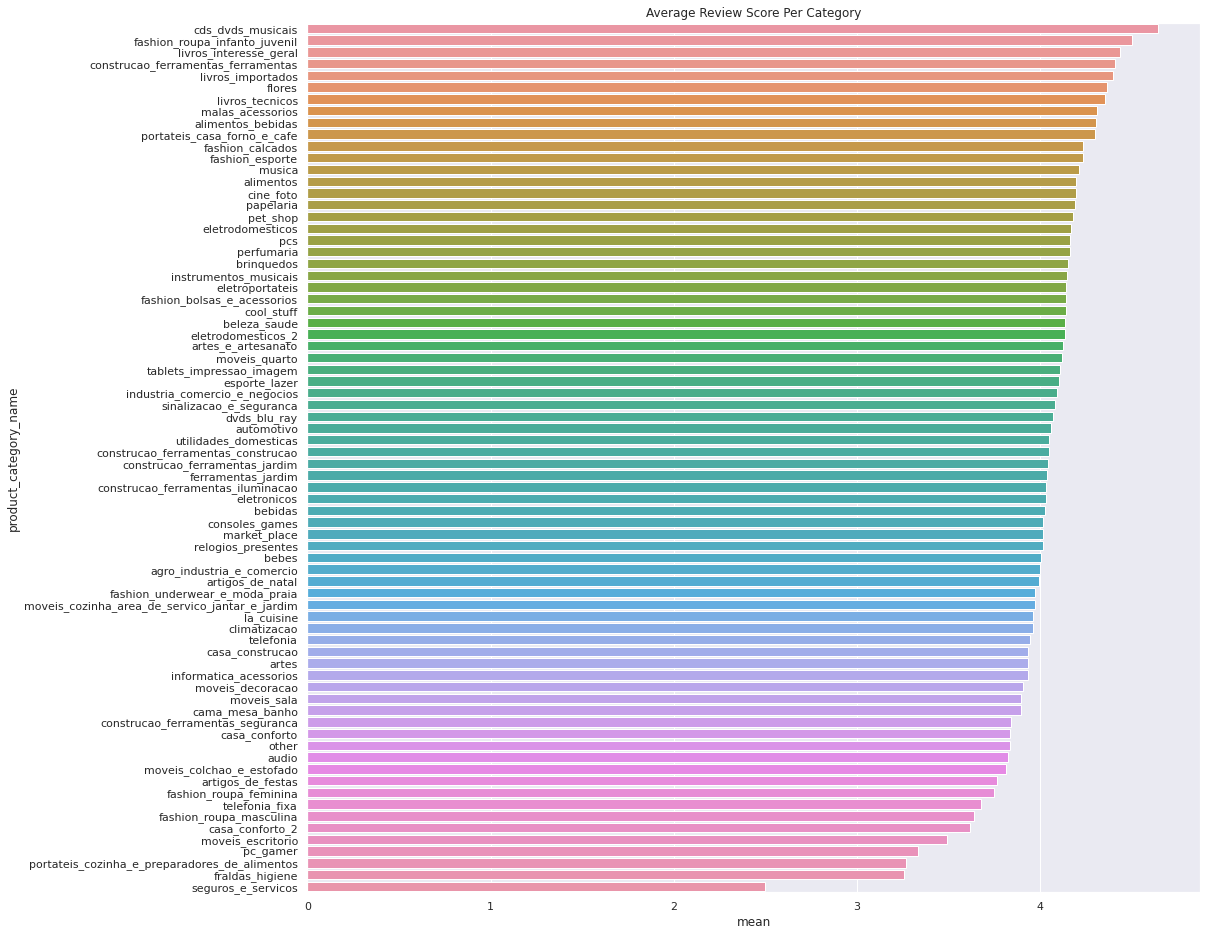

In [ ]:
import seaborn as sns; sns.set(rc={'figure.figsize':(16,16)})

avg_review_score = finalMergedata.groupby('product_category_name', as_index=False).agg({'review_score': ['count', 'mean']})
avg_review_score.columns = ['product_category_name', 'count', 'mean']
avg_review_score = avg_review_score.sort_values(by='mean', ascending=False)

ax = sns.barplot(x="mean", y="product_category_name", data=avg_review_score)
ax.set_title('Average Review Score Per Category')

Text(0.5, 1.0, 'Average Price Per Category')

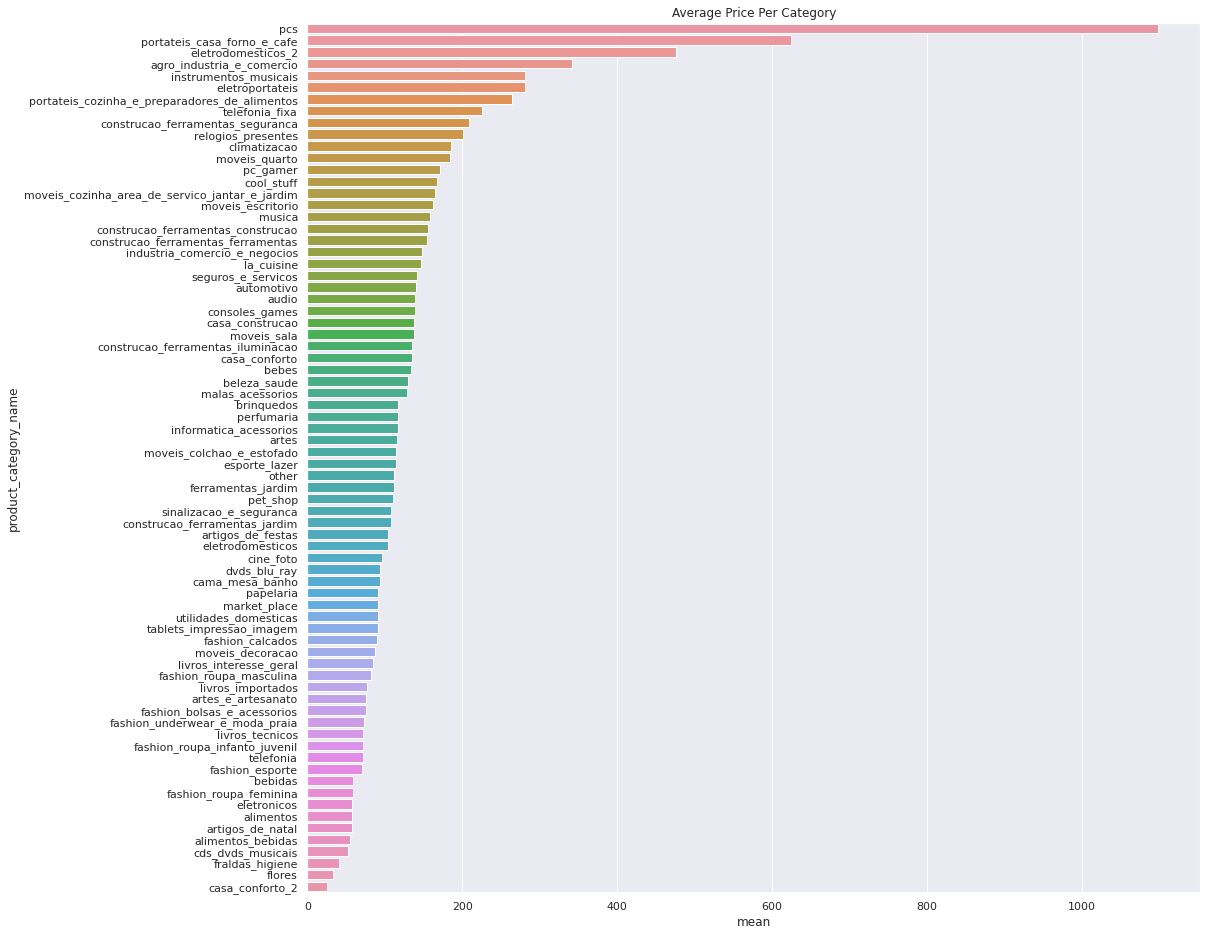

In [ ]:
import seaborn as sns; sns.set(rc={'figure.figsize':(16,16)})

avg_price = finalMergedata.groupby('product_category_name', as_index=False).agg({'price': ['count', 'mean']})
avg_price.columns = ['product_category_name', 'count', 'mean']
avg_price = avg_price.sort_values(by='mean', ascending=False)

ax = sns.barplot(x="mean", y="product_category_name", data=avg_price)
ax.set_title('Average Price Per Category')